# Toy Model #1
## the most straightforward, simple NPZD type model
## fit to the yearly forcing Data from CARIACO

#ToDo:
- Progress Report: Draw Up model structure, preliminary results plotted with data 2,3 pages writing, on slack + small presentation @ group meeting

# initialisation:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
# ExtractEnvFor:
import scipy.interpolate as intrp
import matplotlib as mpl
import time
import pandas

# Interpolation and setting up EnvForcing

In [2]:
# functions adapted from PhytoSFDM Model
def firstderivspl(Forcing, time, k=3, s=None):
    """
    Method to calculate the first derivative of an interpolated spline.

    Parameters
    ----------
    time: in days
    kind: the type of interpolation either linear, cubic, spline or
           piecewise polynomial
    k: Degree of the smoothing spline
    s: Positive smoothing factor used to choose the number of knots

    Returns
    -------
    The first derivative of the temporally interpolated environmental forcing spline.
    """
    outForcing = Forcing  # spatialave(Forcing)
    tmonth = np.linspace(0., 365., 13) #HERE deprecation warning due to 13. <- float, should be int
    newt = np.mod(time, 365.)
    outintp = intrp.UnivariateSpline(tmonth, outForcing, k=k, s=s)
    return outintp.derivative()(newt)

def dailyinterp(Forcing, time, kind='spline', k=3, s=None):
    """
    Method to interpolate from monthly to daily environmental data.

    Parameters
    -----
    time: in days
    kind: the type of interpolation either linear, cubic, spline or piecewise polynomial
    k: Degree of the smoothing spline
    s: Positive smoothing factor used to choose the number of knots

    Returns
    -------
    The temporally interpolated environmental forcing.
    """
    outForcing = Forcing  # spatialave(Forcing)

    tmonth = np.linspace(0., 12., 13) #HERE again, deprecation warning
    newt = np.mod(time, 365.) * 12. / 365.
    if kind == 'spline':
        outintp = intrp.UnivariateSpline(tmonth, outForcing, k=k, s=s)
        return outintp(newt)
    elif kind == 'PWPoly':
        outintp = intrp.PchipInterpolator(tmonth, outForcing)
        return outintp(newt)
    else:
        outintp = intrp.interp1d(tmonth, outForcing, kind=kind)
        return outintp(newt)

In [3]:
# parameters for interpolation
kmld = 3
smld = 0
kindmld = "spline"
kn0x = 5
sn0x = None
kindn0x = "spline"
kpar = 5
spar = None
kindpar = "spline"
ksst = 5
ssst = None
kindsst = "spline"
ksi0x = 5
ssi0x = None
kindsi0x = "spline"

In [4]:
# read environmental forcings
MLDfile = pandas.read_csv('CARIACO_forcing01/MLD')
MLD = list(MLDfile['press'])
MLD.append(MLDfile['press'][0])

NOXfile = pandas.read_csv('CARIACO_forcing01/N0')
NOX = list(NOXfile['as.numeric(NO3_NO2)'])
NOX.append(NOXfile['as.numeric(NO3_NO2)'][0])

SiOXfile = pandas.read_csv('CARIACO_forcing01/Si0')
SiOX = list(SiOXfile['as.numeric(Silicate)'])
SiOX.append(SiOXfile['as.numeric(Silicate)'][0])

SSTfile = pandas.read_csv('CARIACO_forcing01/SST')
SST = list(SSTfile['temp'])
SST.append(SSTfile['temp'][0])

PARfile = pandas.read_csv('CARIACO_forcing01/PAR')
PAR = list(PARfile['value'])
PAR.append(PARfile['value'][0])

# Plotting the yearly forcing:

In [5]:
#make plot larger and more visible on dark background:
plt.rcParams['figure.figsize'] = [7, 6]
plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'})

plt.rcParams['figure.dpi']= 300

In [6]:
MLD #example of structure of forcing files (monthly medians of scatter data)

[23.86725,
 30.259058823529397,
 21.6045,
 21.410470588235302,
 19.4085625,
 17.5516875,
 14.293533333333302,
 14.8595882352941,
 17.0455,
 15.0955625,
 18.809764705882397,
 22.950176470588197,
 23.86725]

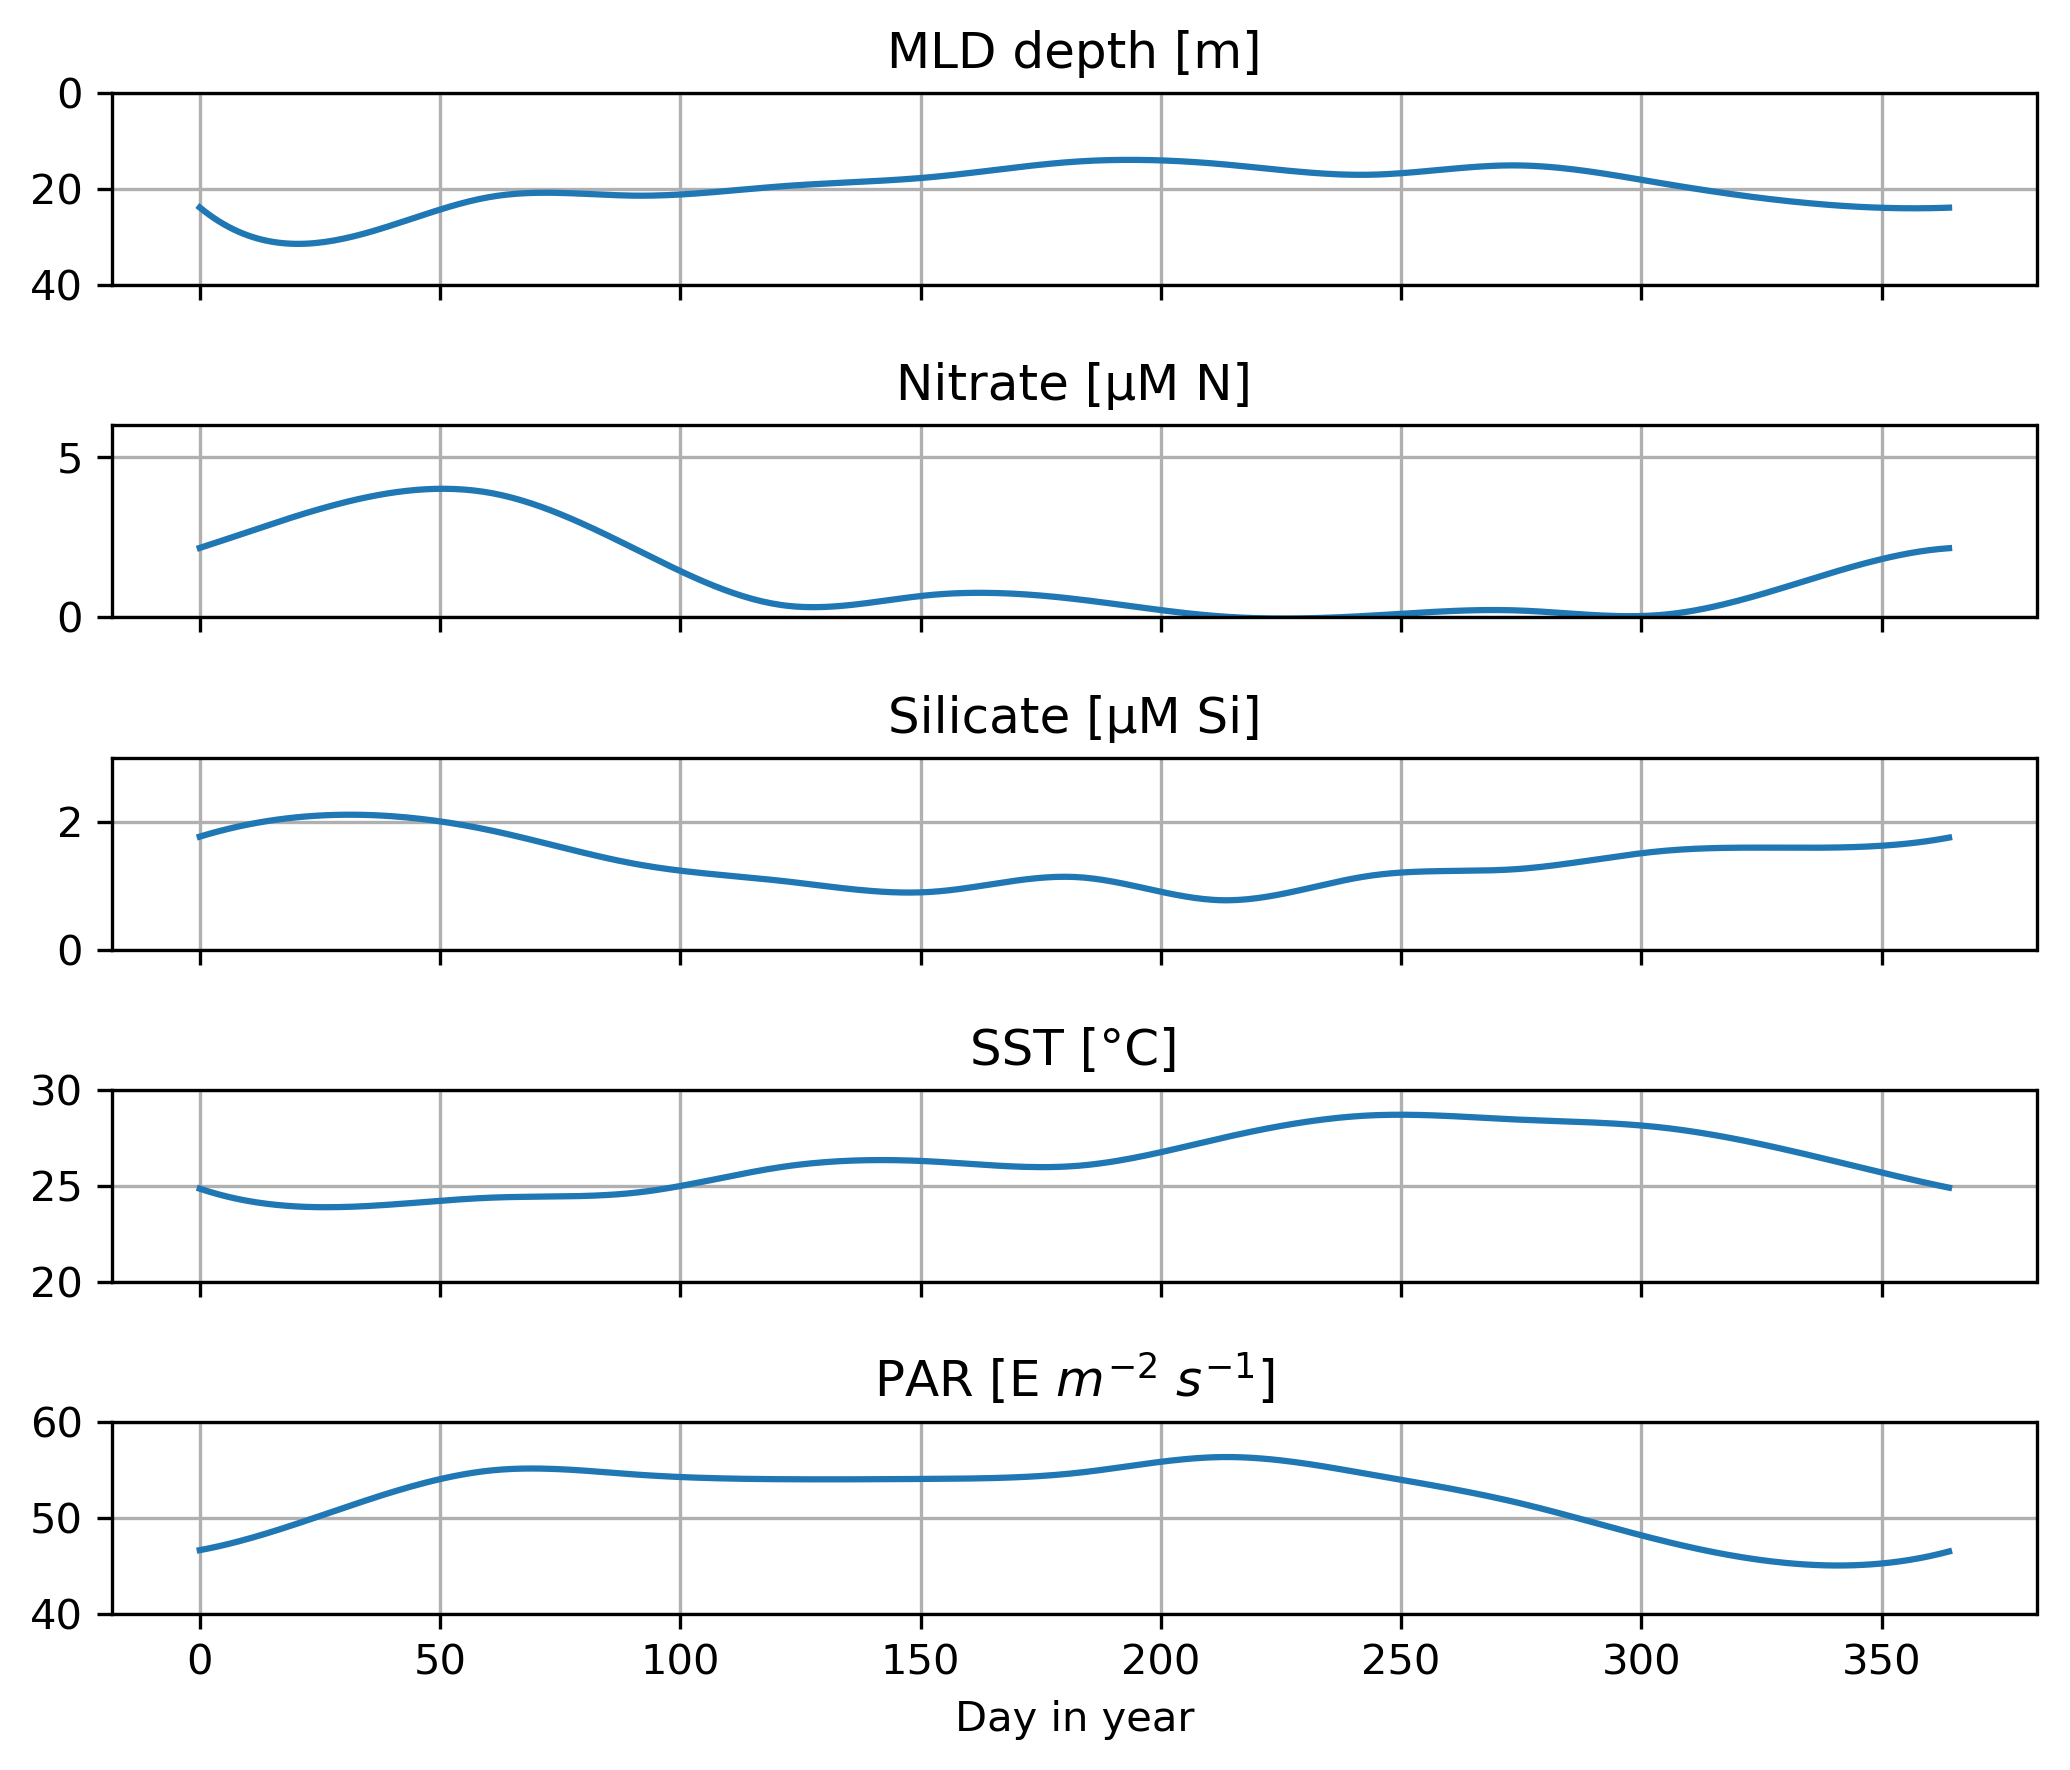

In [7]:
t_forcingplot = np.arange(0., 1 * 365., 1.0)

forcing_MLD = dailyinterp(MLD, t_forcingplot, kind=kindmld, k=kmld, s=smld)
forcing_NOX = dailyinterp(NOX, t_forcingplot, kind=kindmld, k=kmld, s=smld)
forcing_SiOX = dailyinterp(SiOX, t_forcingplot, kind=kindmld, k=kmld, s=smld)
forcing_SST = dailyinterp(SST, t_forcingplot, kind=kindmld, k=kmld, s=smld)
forcing_PAR = dailyinterp(PAR, t_forcingplot, kind=kindmld, k=kmld, s=smld)

fig, (fx1, fx2, fx3, fx4, fx5) = plt.subplots(5, 1, sharex='col', sharey='row')
# MLD
fx1.plot(t_forcingplot, forcing_MLD)
fx1.set_ylim(0,40)
fx1.set_title('MLD depth [m]')
fx1.invert_yaxis()
fx1.grid()

# NOX
fx2.plot(t_forcingplot, forcing_NOX)
fx2.set_ylim(0,6)
fx2.set_title('Nitrate [µM N]')
fx2.grid()

# SiOX
fx3.plot(t_forcingplot, forcing_SiOX)
fx3.set_ylim(0,3)
fx3.set_title('Silicate [µM Si]')
fx3.grid()

# SST
fx4.plot(t_forcingplot, forcing_SST)
fx4.set_ylim(20,30)
fx4.set_title('SST [°C]')
fx4.grid()

# PAR
fx5.plot(t_forcingplot, forcing_PAR)
fx5.set_ylim(40,60)
fx5.set_title('PAR [E $m^{−2}$ $s^{−1}$]')
fx5.grid()


#fx1.set_title('Interpolated Forcings')
fx5.set_xlabel('Day in year')


plt.tight_layout()
plt.show()

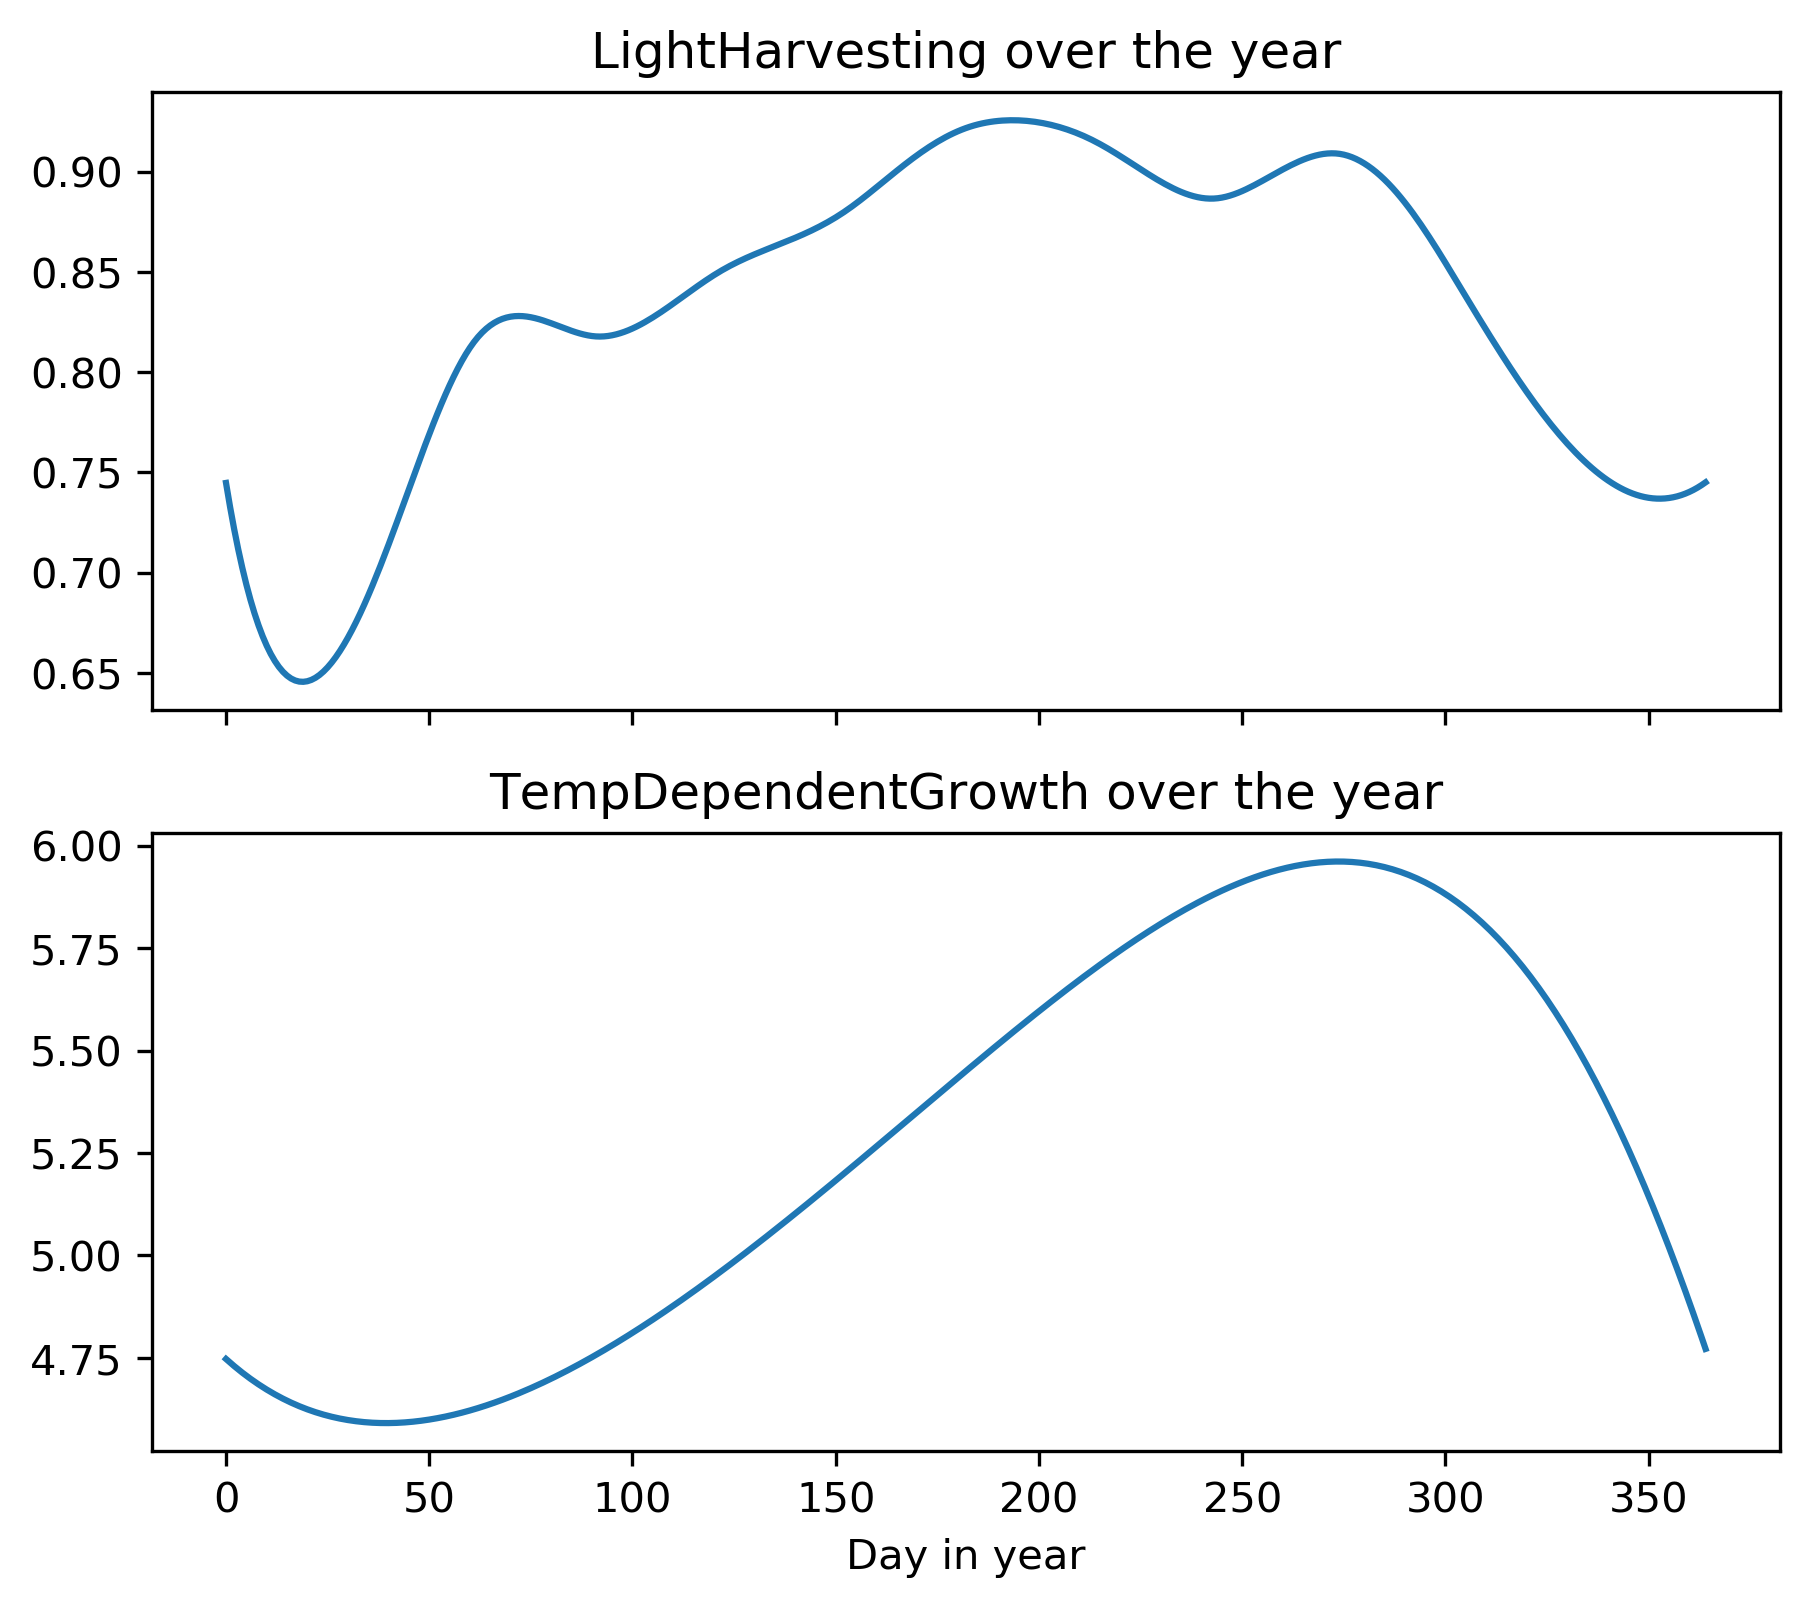

In [9]:
# plot light harvesting function
kw_test = 0.1                   # Light attenuation constant (m^-1)
OptI_test = 30.                 # Optimum irradiance (einstein*m^-2*d^-1)

LightHarvesting = 1. / (kw_test * dailyinterp(MLD, t_forcingplot, kind=kindmld, k=kmld, s=smld)) * \
                (-np.exp(1. - dailyinterp(PAR, t_forcingplot, kind=kindpar, k=kpar, s=spar) / OptI_test) - \
                (-np.exp((1. - (dailyinterp(PAR, t_forcingplot, kind=kindpar, k=kpar, s=spar) * \
                np.exp(-kw_test * dailyinterp(MLD, t_forcingplot, kind=kindmld, k=kmld, s=smld))) / OptI_test))))

TemperatureDepGrowth = np.exp(0.063 * dailyinterp(SST, t_forcingplot, kind=kindsst, k=ksst, s=ssst))
    
fig2, (LH, TDG) = plt.subplots(2, 1, sharex='col', sharey='row')
LH.plot(t_forcingplot, LightHarvesting)
LH.set_title('LightHarvesting over the year')


TDG.plot(t_forcingplot, TemperatureDepGrowth)
TDG.set_title('TempDependentGrowth over the year')
TDG.set_xlabel('Day in year')
plt.show()

LightHarvesting:
The light limitation term, Ψ(I), integrates the photosynthetically active radiation (PAR) I through the mixed layer by using Steele's formulation

TempDepGrowth:
f(T) = e<sup>0.063 · T</sup> represents Eppley's formulation of temperature-dependent growth


# Actual Model

In [22]:
def simpleNPZD(x, t):
    N = x[0] # Nitrate
    Si = x[1] # Silicate
    Z = x[2] # Zooplankton
    D = x[3] # Detritus
    P = x[4] # Phytoplankton
    y = np.zeros(len(x)) #initalize vector of derivatives
    
    # Interpolations of Forcings
    int_MLD = dailyinterp(MLD, t, kind=kindmld, k=kmld, s=smld)
    int_NOX = dailyinterp(NOX, t, kind=kindn0x, k=kn0x, s=sn0x)
    int_SIOX = dailyinterp(SiOX, t, kind=kindsi0x, k=ksi0x, s=ssi0x)
    int_PAR = dailyinterp(PAR, t, kind=kindpar, k=kpar, s=spar)
    int_SST = dailyinterp(SST, t, kind=kindsst, k=ksst, s=ssst)
    
    # Derivatives of Forcings
    deriv_MLD = firstderivspl(MLD, t, k=kmld, s=smld)
    
    ## Non-P related processes
    # Mixing Processes
    DiffusiveMixing = (kappa + deriv_MLD) / int_MLD
    ActiveMixing = deriv_MLD / int_MLD
    
    # Zooplankton
    Ped = P * gr_p # Edible Phytoplankton
    ZooMortality = moZ * Z ** 2 #quadratic loss term for closure
    ZooMixing = Z * ActiveMixing
    
    # Mineralisation
    NMineralization = deltaD_N * D
    SiMineralization = deltaD_Si * D
    
    # Detritus
    DetritusMixing = D * DiffusiveMixing
    
    # Nutrient Mixing
    NMixing = DiffusiveMixing * (int_NOX - N)
    SiMixing = DiffusiveMixing * (int_SIOX - Si)
    
    y[0] = NMineralization + NMixing 
    y[1] = SiMineralization + SiMixing
    y[2] = - ZooMortality - ZooMixing
    y[3] = ZooMortality - NMineralization - SiMineralization- DetritusMixing

    
    ## P related processes
    # Nutrient uptake
    N_Uptake = N / (N + U_N)       #!
    
    Si_Uptake = Si / (Si + U_Si)   #!

    # Light and Temperature 
    LightHarvesting = 1. / (kw * int_MLD) * \
                (-np.exp(1. - int_PAR / OptI) - \
                (-np.exp((1. - (int_PAR * np.exp(-kw * int_MLD)) / OptI))))
                          
    TemperatureDepGrowth = np.exp(0.063 * int_SST)
    
    # Phytoplankton Growth
    Gains = muP * min(N_Uptake, Si_Uptake) * LightHarvesting * TemperatureDepGrowth

    # Phytoplankton Losses
    Grazing = muZ * Z / (Ped + Kp)       #!
    Sinking = v / int_MLD                #!
    OtherPMortalities = moP
    Losses = Grazing + Sinking + OtherPMortalities + DiffusiveMixing
                          
    # Zooplankton Grazing
    ZooGrowth = deltaZ * Grazing * P
    UnassimilatedProduction = (1. - deltaZ) * Grazing * P

    
    y[0] = y[0] - P * Gains # Nitrate drawdown
    y[1] = y[1] - P * ratioSi * Gains # Silicate drawdown
                          
    y[2] = y[2] + ZooGrowth #Zooplankton growth                   
    y[3] = y[3] + UnassimilatedProduction + P * OtherPMortalities # Detritus
                          
    y[4] = P * (Gains - Losses) #Phytoplankton growth
    
    return y

In [23]:
# initialize parameters:
N0 = np.mean(NOX)             # Initial Nitrate concentration (mmol*m^-3)
Si0 = np.mean(SiOX)           # Initial Silicate concentration (mmol*m^-3)
Z0 = 0.1                      # Initial Zooplankton concentration (mmol*m^-3) 
D0 = 0.01                     # Initial Detritus concentration (mmol*m^-3)
P0 = 0.01                     # Initial Phytoplankton concentration (mmol*m^-3)


initcond = np.concatenate(([N0], [Si0], [Z0], [D0], [P0]), 0)
timedays_model = np.arange(0., 5 * 365., 1.0)

In [24]:
# params
kappa = 0.1                # Diffusive mixing across thermocline (m*d^-1)
kw = 0.1                   # Light attenuation constant (m^-1)
OptI = 30.                 # Optimum irradiance (einstein*m^-2*d^-1)

deltaD_N = 0.1             # Nitrate Mineralization rate (d^-1)
deltaD_Si = 0.1            # Silicate Mineralization rate (d^-1)

U_N = 0.0614     #!        # Nitrate Half Saturation Constant
U_Si = 0.0614    #!        # Silicate Half Saturation Constant                                   

v = 2.1e+18      #!        # Sinking

muP = 1.5                  # Phytoplankton max growth rate (d^-1)
moP = 0.05                 # Phytoplankton mortality rate (d^-1)
Kp = 0.1                   # Phytoplankton half-saturation constant (mmol*m^-3)

ratioSi = 1                # ration of N to Si in phytoplankton

gr_p = 0.1                 # Portion of Phytoplankton being grazed
muZ = 1.35                 # Zooplankton maximum grazing rate (d^-1)
moZ = 0.3                  # Zooplankton mortality (d^-1)
deltaZ = 0.31              # Zooplankton Grazing assimilation coefficient (-)

# Integration

In [25]:
#integrate Silicate+Nitrate Model:
tos = time.time()
print('starting integration')
outarray = odeint(simpleNPZD, initcond, timedays_model)#, rtol=1e-12, atol=1e-12)
tos1 = time.time()
print('finished after %4.3f sec'%(tos1-tos))

starting integration
finished after 3.167 sec


In [27]:
#truncate outarraySiNO to last year of 5:
outarray_ly = outarray[1460:1825]

In [28]:
timedays = timedays_model[1:366]

# plot!  

In [10]:
# read yearly data (for comparison to model) from Cariaco
ChlA = pandas.read_csv('../CARIACOModelingProject/Data/DataFiles_Processed/ChlA_bottle_yearly_surface.csv')

NO3NO2 = pandas.read_csv('../CARIACOModelingProject/Data/DataFiles_Processed/NO3NO2_bottle_yearly_surface.csv')

SiOH_UDO = pandas.read_csv('../CARIACOModelingProject/Data/DataFiles_Processed/SiOH_UDO_bottle_yearly_surface.csv')
SiOH_USF = pandas.read_csv('../CARIACOModelingProject/Data/DataFiles_Processed/SiOH_USF_bottle_yearly_surface.csv')

# Zooplankton!

In [32]:
colors = ['#00C90D', '#01939A', 'black', 'grey', '#E2680B']
alphas = [1., 0.8, 0.6, 0.4]
lws = [1, 2.5, 4, 5.5]

# artist for legends
FullArtist = plt.Line2D((0, 1), (0, 0), c=colors[4], alpha=alphas[1], lw=lws[0])

(-0.1, 5)

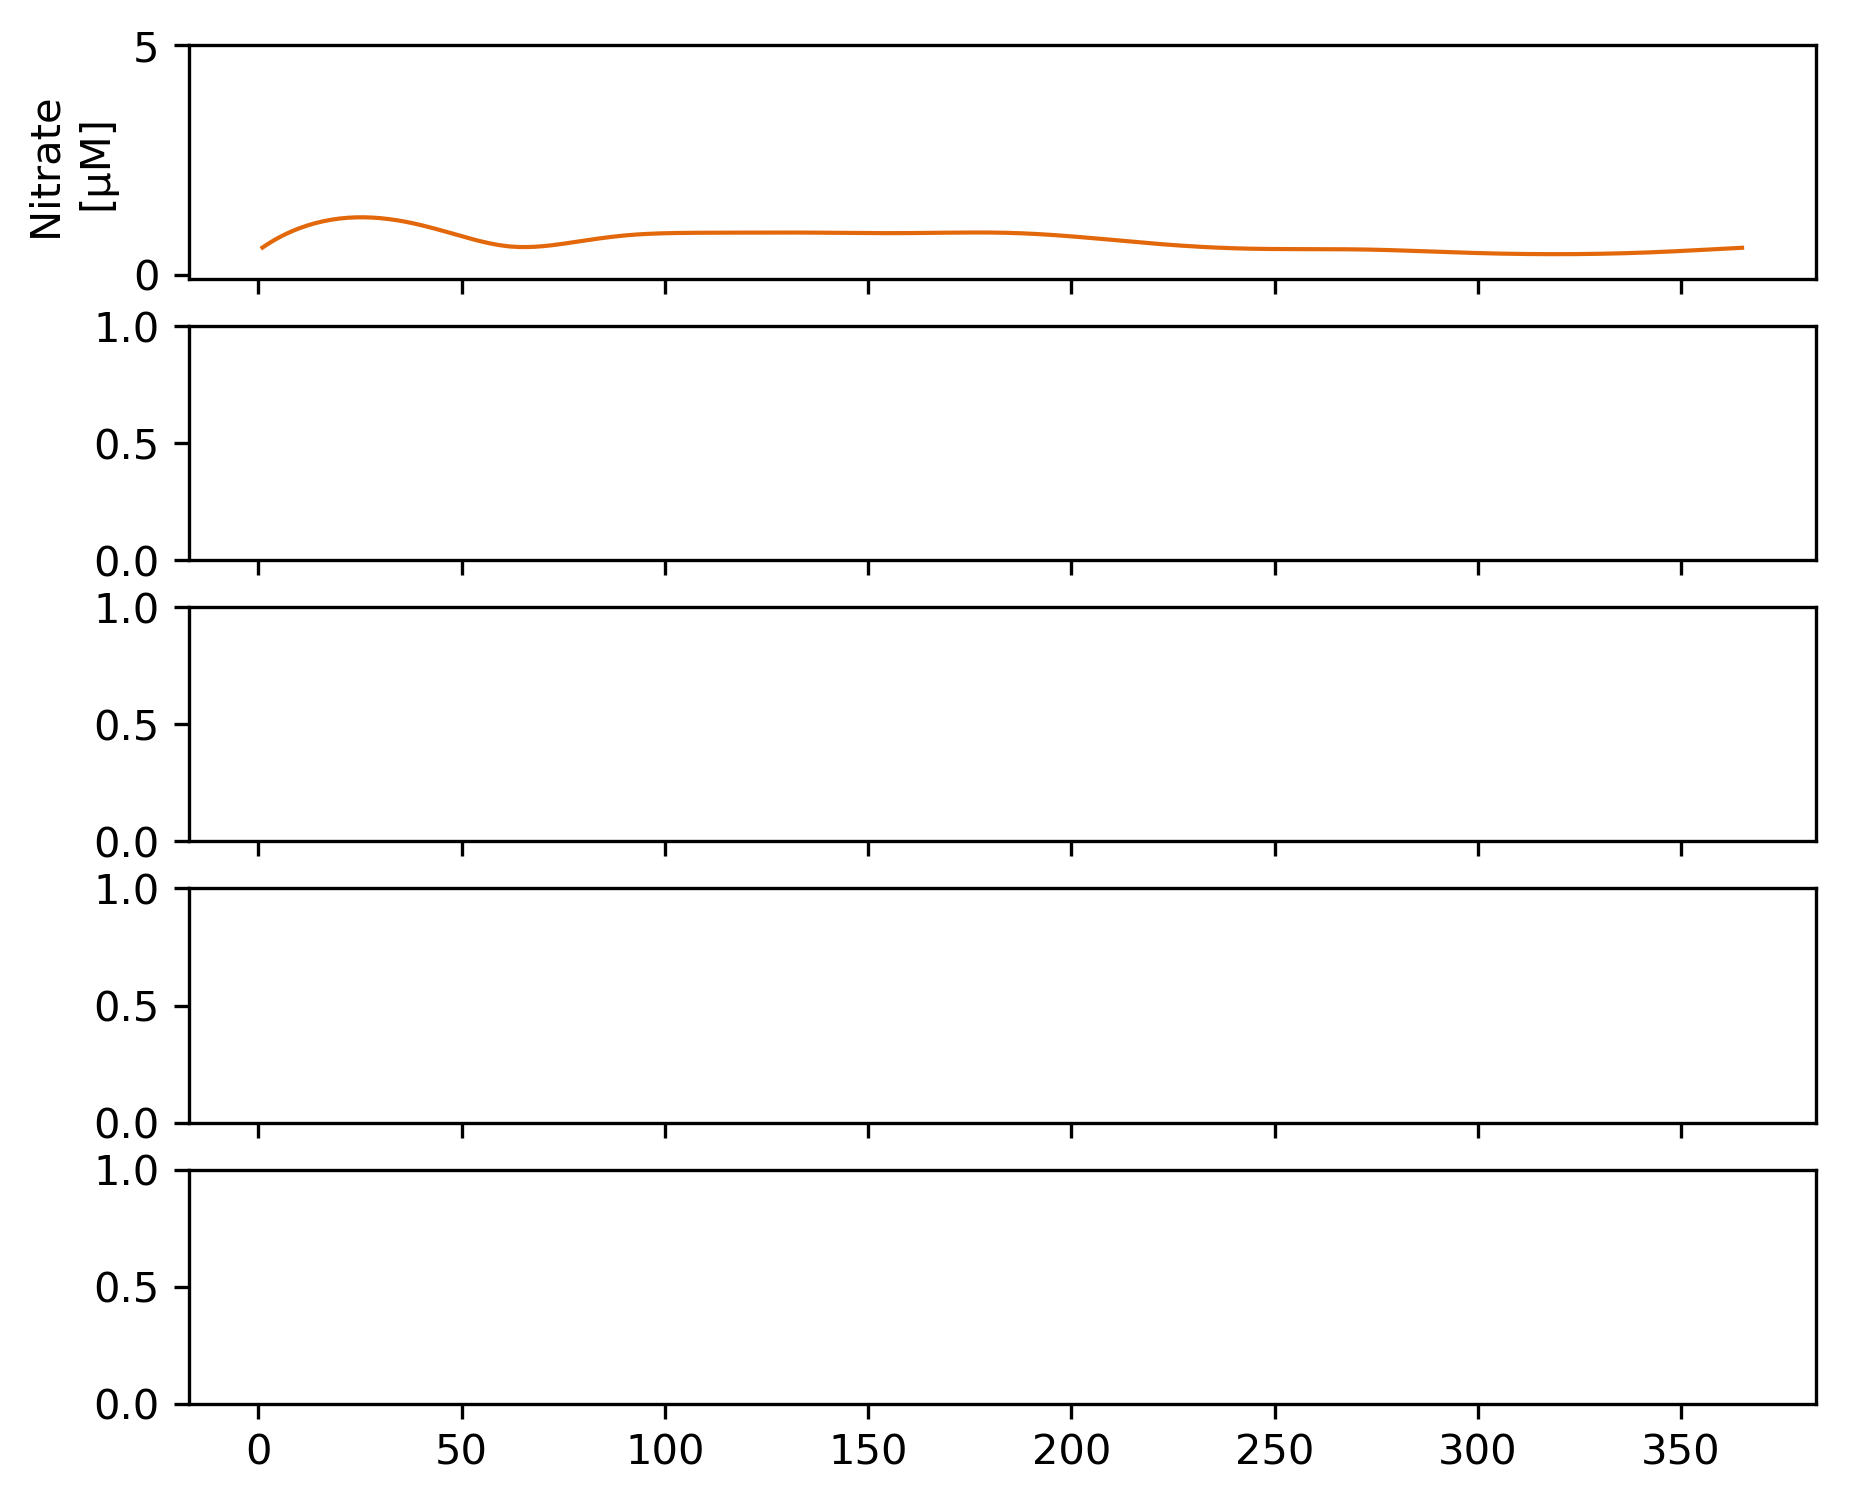

In [34]:
# Figure 1
f1, (ax1, axs1, ax2, ax3, ax4) = plt.subplots(5, 1, sharex='col', sharey='row')
# N
ax1.plot(timedays, outarray_ly[:, 0], c=colors[4], lw=lws[0], alpha=alphas[0], label='Model')
ax1.set_ylabel('Nitrate \n' '[µM]', multialignment='center', fontsize=10)
ax1.set_ylim(-0.1, 5)


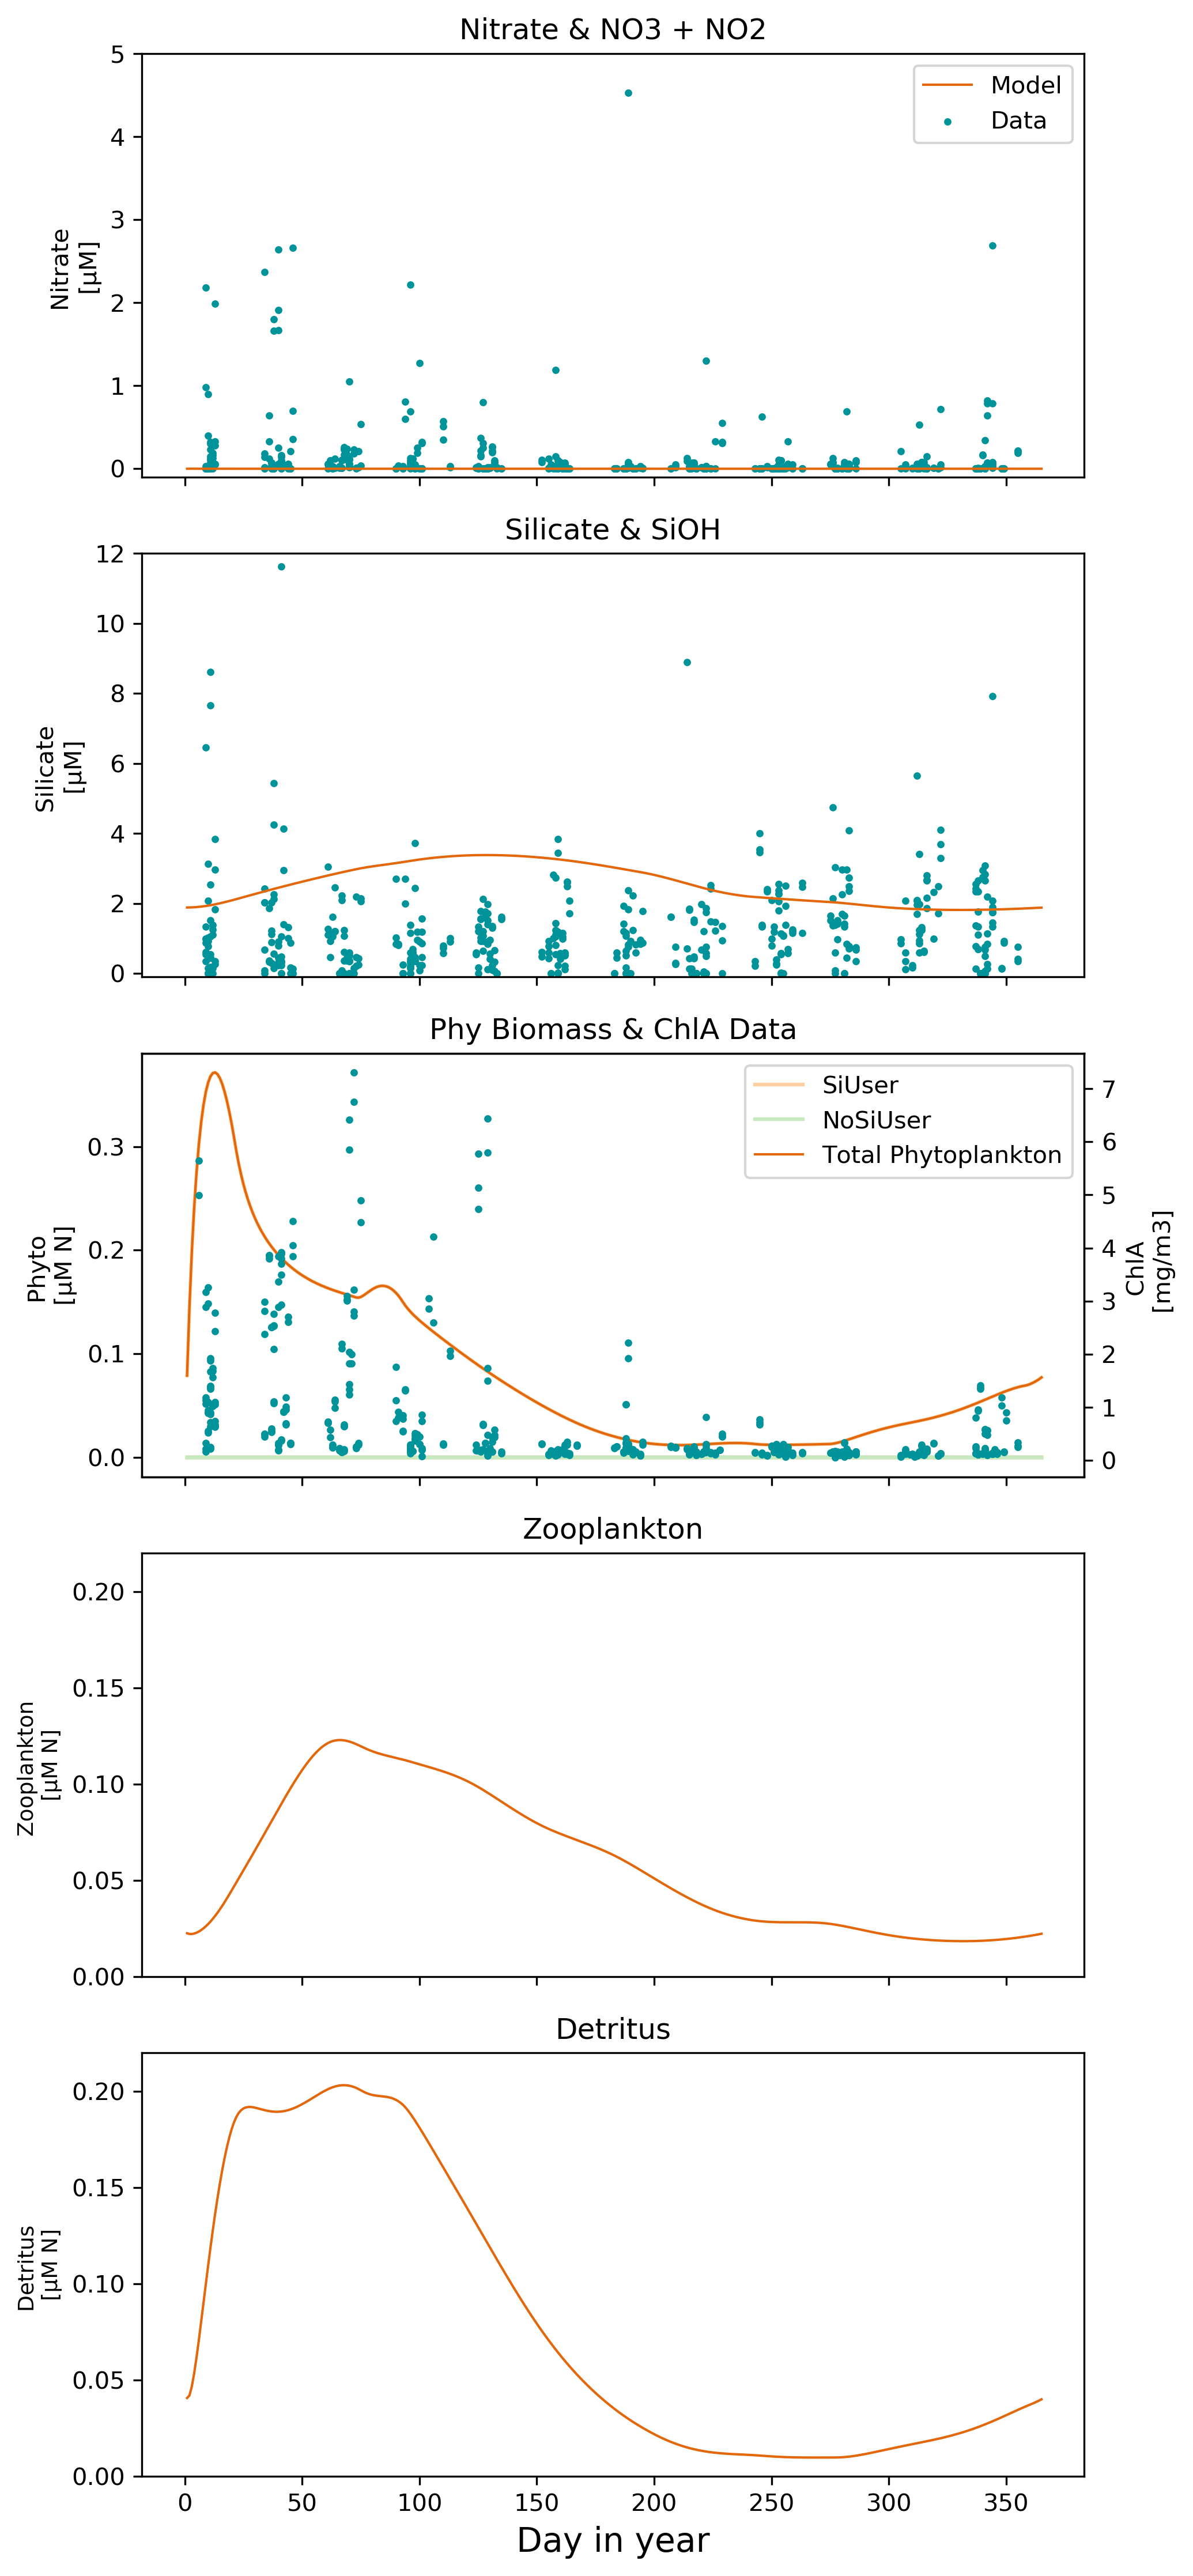

In [18]:
# Figure NO.2 SILICATE
f2, (ax1, axs1, ax2, ax3, ax4) = plt.subplots(5, 1, sharex='col', sharey='row')
# N
ax1.plot(timedays, outarraySiNo[:, 0], c=colors[4], lw=lws[0], alpha=alphas[0], label='Model')
ax1.set_ylabel('Nitrate \n' '[µM]', multialignment='center', fontsize=10)
ax1.set_ylim(-0.1, 5)

#ax1.ticklabel_format(style='sci',scilimits=(0,0))

ax1.scatter(NO3NO2['yday'].values, NO3NO2['NO3NO2'].values, c=colors[1],s=4.3, label='Data')
ax1.set_title('Nitrate & NO3 + NO2')
ax1.legend(loc=1)

# Si
axs1.plot(timedays, outarraySiNo[:, 3+NoMtypeSi], c=colors[4], lw=lws[0], alpha=alphas[0])
axs1.set_ylabel('Silicate \n' '[µM]', multialignment='center', fontsize=10)
axs1.set_ylim(-0.1, 12)

axs1.scatter(SiOH_USF['yday'].values, SiOH_USF['SiOH'].values, c=colors[1],s=4.3)
axs1.set_title('Silicate & SiOH')

#NOW PLOT BOTH Phytoplankton together in one box
#PHYTO
for i in range(NoMtypeSi):
    ax2.plot(timedays, outarraySiNo[:, 3+i], c=orangescmapSi[1])

for i in range(NoMtypeNo):
    ax2.plot(timedays, outarraySiNo[:, 3+NoMtypeSi+1+i], c=orangescmapNo[1])

ax2.plot(0,0,c= orangescmapSi[1], label = 'SiUser') # just to include in legend / small hack
ax2.plot(0,0,c= orangescmapNo[1], label = 'NoSiUser') # just to include in legend / small hack

ax2.plot(timedays, ptot, c=colors[4], lw=lws[0], alpha=alphas[0], label='Total Phytoplankton')

ax2.set_ylabel('Phyto \n' '[µM N]', multialignment='center', fontsize=10)

ax2_tx = ax2.twinx()
ax2_tx.scatter(ChlA['yday'].values, ChlA['ChlA'].values, c=colors[1],s=4.3)
ax2_tx.set_ylabel('ChlA \n [mg/m3]')

ax2.set_title('Phy Biomass & ChlA Data')
ax2.legend()


# Z
ax3.plot(timedays, outarraySiNo[:, 1], c=colors[4], lw=lws[0], alpha=alphas[0])
ax3.set_ylabel('Zooplankton \n' '[µM N]', multialignment='center', fontsize=9)
ax3.tick_params('y', labelsize=10)

ax3.set_title('Zooplankton')
ax3.set_ylim(0, 0.22)

# D
ax4.plot(timedays, outarraySiNo[:, 2], c=colors[4], lw=lws[0], alpha=alphas[0])
ax4.set_ylabel('Detritus \n' '[µM N]', multialignment='center', fontsize=9)

ax4.set_title('Detritus')

ax4.set_xlabel('Day in year', fontsize=14)
ax4.set_ylim(0, 0.22)
# Legend


#plt.subplots_adjust(hspace=0.01)
f2.set_figheight(15)
plt.tight_layout()
plt.show()